In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=274eebe62cbfb2ca6cdc381eec73ae172db91b6fa9029db62e8db650154c0de9
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from google.colab import drive
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Bayesian Optimization을 이용하는 모델링

## 7, 14, 28일 예측(비시계열) - 토마토

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/선대팀_주제분석/최종데이터/carrot_lag7.csv",encoding = 'cp949')

In [ ]:
data = data.dropna().reset_index(drop = True)

In [ ]:
data

,date,요일,가격,중국화폐종가,당근거래량,당근_강수량_지속영향_size15,daedong_stock,etf,서울대_s2
0,2016.1.20,수요일,805,183.820000,306456.5,0.875928,8940.000000,6270.000000,0.346405
1,2016.1.21,목요일,829,182.940000,206349.0,0.923937,8770.000000,6200.000000,0.129630
2,2016.1.22,금요일,840,182.030000,199165.7,0.383444,8790.000000,6250.000000,0.219895
3,2016.1.23,토요일,778,182.803160,269055.6,0.943901,8918.650476,6295.516982,0.266667
4,2016.1.25,월요일,813,182.340000,448616.0,1.044135,8940.000000,6275.000000,0.203980
...,...,...,...,...,...,...,...,...,...
1442,2020.9.23,수요일,1792,171.850000,408298.0,28.795393,6460.000000,4370.000000,0.264673
1443,2020.9.24,목요일,1565,171.170000,423233.2,10.749974,6240.000000,4315.000000,0.264807
1444,2020.9.25,금요일,1773,172.050000,400527.2,10.014340,6180.000000,4325.000000,0.261844
1445,2020.9.26,토요일,1405,171.733737,187076.2,8.081977,6264.323351,4351.120818,0.259015


In [ ]:
data7 = data.copy()

remove_list7 = list()

for i in list(data7.index) : 
  try:
    if data7['요일'][i] != data7['요일'][i+4] and data7['요일'][i] != data7['요일'][i+5] and data7['요일'][i] != data7['요일'][i+6] :
      remove_list7.append(i)
  except: 
    break

data7 = data7.drop(remove_list7, axis = 0).reset_index(drop = True)

In [ ]:
# y값이 7일 차이나는 데이터 프레임 만들기

day = 6

data7['가격'][:-day] = data7['가격'][day:]
data7['가격'][-day:] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data7 = data7.dropna().reset_index(drop = True)

In [ ]:
# validation할 기간은 2020-07-07의 7일 후 ~ 2020-08-03의 7일 후

last_day7 = list(data7['date']).index('2020.8.31')
train7 = data7.iloc[:last_day7+1, :]

In [ ]:
# X와 y를 분리

def splitFunction(data) : 
  data_X = data.drop('가격',axis = 1)
  data_y = data['가격']
  return data_X, data_y

train7_X, train7_y = splitFunction(train7)

In [ ]:
test_index = list(train7['date'].reset_index(drop = True)).index("2020.7.7") # 우리가 비교할 첫 날짜 

In [ ]:
# 우리는 기존의 방법이 아닌 조금 새로운 방식의 CV가 필요하므로 이를 정의
# 참고로 아래는 Expanding 방식입니다.

class JHLeeTimeSeriesSplit() : 
  def __init__(self) :
    self.data = train7

  def get_n_splits(self, groups) : 
    return  
  
  def split(self, X, y = None, groups = None) :
    for day in range(24) : 

      train_split_data = train.iloc[:test_index+day,:] # 각 시행시 test하는 날짜 전까지가 train
      train_indices = list(train_split_data.index)

      test_indices = list()
      test_indices.append(test_index+day) # test할 날짜를 저장

      yield train_indices, test_indices

In [ ]:
def XGB_cv(max_depth, gamma) : # 괄호 안에는 각 모델에서 튜닝할 parameter들과 데이터들을 넣으면 됩니다.

# 모델 선언
# 참고로, 베이지안 최적화는 항상 실수값이 인풋으로 들어가므로, max_depth처럼
# 정수형 인자를 필요로 하는경우 반드시 int나 round를 사용해 정수형으로 만들어줘야합니다.

  model = XGBRegressor(random_state = 1234,
                            max_depth = int(max_depth),
                            gamma = gamma,
                       objective = 'reg:squarederror')


  cv = JHLeeTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                    train_X,
                                    train_y,
                                    cv = cv,
                                    scoring = 'neg_mean_squared_error') # -MSE를 의미

  rmse_scores_part = np.sqrt(-mse_scores_part) # -(-MSE)의 sqrt = RMSE    
  rmse_scores = np.mean(rmse_scores_part) # 28일동안 평가했으므로 28일간의 평균 rmse가 필요

  return -rmse_scores # 베이지안 최적화에서는 최대값만을 기준으로 할 수 있으므로 -을 붙이고 최대를 구하면 실은 최소값을 구하는 것                           

In [ ]:
# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"max_depth" : (1, 100),
           "gamma" : (0.0001, 5000)}

In [ ]:
train_X, train_y = train7_x.drop(['date','요일'],axis = 1, train7_y
BO = BayesianOptimization(f = XGB_cv, # 위에서 정의한 cv 함수
                        pbounds = pbounds, # 위에서 정의한 파라미터들의 범위
                        verbose = 2, # 과정을 나타내줌
                        random_state = 1234) # 시드 고정 필수
BO.maximize(init_points = 10, n_iter = 10, acq = 'ei',xi = 0.01) # init point는 시작할 때의 개수, n_iter는 그 이후에 돌릴 개수

|   iter    |  target   |   gamma   | max_depth |
-------------------------------------------------
|  1        | -144.5    |  957.6    |  62.59    |
|  2        | -138.9    |  2.189e+0 |  78.75    |
|  3        | -131.9    |  3.9e+03  |  27.99    |
|  4        | -139.7    |  1.382e+0 |  80.39    |
|  5        | -131.6    |  4.791e+0 |  87.72    |
|  6        | -145.1    |  1.789e+0 |  50.6     |
|  7        | -140.2    |  3.417e+0 |  71.56    |
|  8        | -143.6    |  1.851e+0 |  56.56    |
|  9        | -113.6    |  2.515e+0 |  2.363    |
|  10       | -137.3    |  3.864e+0 |  88.38    |
|  11       | -121.7    |  2.521e+0 |  4.964    |
|  12       | -131.5    |  2.519e+0 |  3.057    |
|  13       | -130.5    |  4.79e+03 |  84.61    |
|  14       | -137.9    |  2.524e+0 |  6.975    |
|  15       | -121.8    |  2.514e+0 |  1.553    |
|  16       | -135.3    |  2.516e+0 |  6.936    |
|  17       | -121.7    |  2.522e+0 |  4.43     |
|  18       | -130.4    |  4.794e+0 |  86.13    |


In [ ]:
# 모델 생성
model_list = list()
parameters = BO.max['params']# 위의 결과들을 딕셔너리로 반환시켜준다.

# 최적의 조합

max_depth = int(parameters['max_depth'])
gamma = parameters['gamma']
print("rmse: %.3f,  gamma: %d, max_depth: %d"%(-BO.max['target'],gamma, max_depth))

model7 = XGBRegressor(random_state = 1234,
                        max_depth = max_depth,
                        gamma = gamma,
                        objective = 'reg:squarederror')

rmse: 113.623,  gamma: 2515, max_depth: 2


In [ ]:
carrot_real_y = pd.read_csv("/content/drive/MyDrive/선대팀_주제분석/최종데이터/carrot_true_y.csv",encoding = 'cp949')

In [ ]:
start_7 = list(carrot_real_y['date']).index('2020.9.8') # 7일 예측에서 예측 시작 날짜와 종료일자 
end_7 = list(carrot_real_y['date']).index('2020.10.5')

In [ ]:
real_value7 = carrot_real_y[start_7 : end_7+1].reset_index(drop = True)

In [ ]:
predict_day7 = ['2020.9.1', '2020.9.2', '2020.9.3', '2020.9.4', '2020.9.5', '2020.9.7',
'2020.9.8', '2020.9.9', '2020.9.10', '2020.9.11','2020.9.12', '2020.9.14', '2020.9.15', '2020.9.16', '2020.9.17',
'2020.9.18', '2020.9.19', '2020.9.21', '2020.9.22','2020.9.23', '2020.9.28'] 

In [ ]:
# predict

predicts = list() # predict 값들을 넣을 리스트 
test_index = list(data7['date'].reset_index(drop = True)).index(predict_day7)

new_train = data7.iloc[:test_index, :].copy()
new_train = new_train.dropna().reset_index(drop = True)

train_X = new_train.drop(['date','요일','가격'], axis = 1).reset_index(drop = True)
train_y = new_train['가격'].reset_index(drop = True)

    
new_test = data7.drop(['date','요일','가격'],axis = 1).reset_index(drop = True)
test_X = new_test.iloc[test_index-1: test_index]

model7.fit(train_X, train_y)
predict = model7.predict(test_X)  # 하루에 대한 예측값
predicts.append(predict) # 하루하루 예측값을 각각 predicts라는 리스트에 저장

In [ ]:
mse7 = mean_squared_error(predicts, real_value7['가격'])
rmse7 = math.sqrt(mse7)
print(rmse7)

384.50521984430134


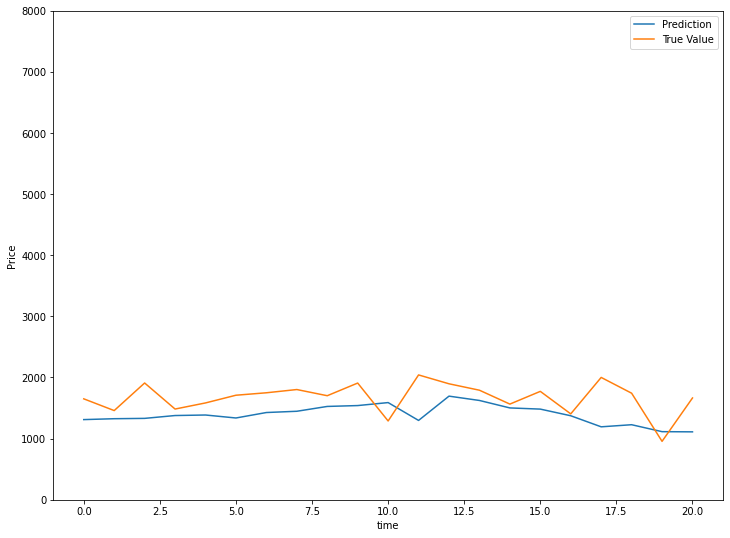

In [ ]:
# 7일 후를 예측한 가격의 그래프

plt.figure(figsize=(12, 9))
plt.plot(predicts)
plt.plot(real_value7['가격'].reset_index(drop = True))
plt.ylabel('Price')
plt.xlabel('time')
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.ylim(0,8000)
plt.show()

## 14일 예측(비시계열) - 토마토

14일과 28일 후는 7일에 생성된 코드의 반복이지만, 데이터가 다르고 예측 날짜 및 모델도 달라지므로 이를 다시 정의해주는 과정

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/선대팀_주제분석/최종데이터/carrot_lag14.csv",encoding = 'cp949')

In [ ]:
data = data.dropna().reset_index(drop = True)

In [ ]:
data

,date,요일,가격,당근거래량,당근_강수량_지속영향_size10,군산대_s4
0,2016.1.14,목요일,692,349016.0,0.044368,0.092308
1,2016.1.15,금요일,748,296235.8,0.555973,0.139785
2,2016.1.16,토요일,733,256431.8,0.050179,0.028571
3,2016.1.18,월요일,875,478153.6,0.152027,0.129032
4,2016.1.19,화요일,809,179968.0,0.366090,0.103627
...,...,...,...,...,...,...
1447,2020.9.23,수요일,1792,408298.0,7.779346,0.132948
1448,2020.9.24,목요일,1565,423233.2,6.020233,0.136688
1449,2020.9.25,금요일,1773,400527.2,5.326877,0.126700
1450,2020.9.26,토요일,1405,187076.2,4.516077,0.122793


In [ ]:
# validation할 기간은 2020-07-07의 14일 후 ~ 2020-08-03의 14일 후입니다.

last_day14 = list(data14['date']).index('2020.8.31')
train14 = data14.iloc[:last_day14+1, :]

In [ ]:
data14 = data.copy()
remove_list14 = list()


for i in list(data14.index) : 
  try:
    if data14['요일'][i] != data14['요일'][i+10] and data14['요일'][i] != data14['요일'][i+11] and data14['요일'][i] != data14['요일'][i+12] :
      remove_list14.append(i)
  except:
    break

data14 = data14.drop(remove_list14, axis = 0).reset_index(drop = True)

In [ ]:
day = 12
data14['가격'][:-day] = data14['가격'][day:]
data14['가격'][-day:] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# X와 y를 분리합시다. 

train14_X, train14_y = splitFunction(train14)

In [ ]:
test_index = list(train14['date'].reset_index(drop = True)).index("2020.7.7") # 우리가 비교할 첫 날짜 

In [ ]:
class JHLeeTimeSeriesSplit() : 
  def __init__(self) :
    self.data = train14 # CV에 이용할 데이터는 train이겠죠

  def get_n_splits(self, groups) : 
    return  
  
  def split(self, X, y = None, groups = None) :
    
    #test_index = list(self.data).index('2020.7.7') # 우리가 비교할 첫 날짜

    for day in range(24) : # 28-4(일요일)일간의 기간을 평가해봅시다

      train_split_data = train.iloc[:test_index+day,:] # 각 시행시 test하는 날짜 전까지가 train
      train_indices = list(train_split_data.index)

      test_indices = list()
      test_indices.append(test_index+day) # test할 날짜를 저장

      yield train_indices, test_indices

In [ ]:
def XGB_cv( max_depth, gamma) : # 괄호 안에는 각 모델에서 튜닝할 parameter들과 데이터들을 넣으면 됩니다.

  # 모델 선언
  # 참고로, 베이지안 최적화는 항상 실수값이 인풋으로 들어가므로, max_depth처럼
  # 정수형 인자를 필요로 하는경우 반드시 int나 round를 사용해 정수형으로 만들어줘야합니다.
  model = XGBRegressor(random_state = 1234,
                            max_depth = int(max_depth),
                            gamma = gamma,
                            objective = 'reg:squarederror')


  cv = JHLeeTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                    train_X,
                                    train_y,
                                    cv = cv,
                                    scoring = 'neg_mean_squared_error') # -MSE를 의미

  rmse_scores_part = np.sqrt(-mse_scores_part) # -(-MSE)의 sqrt = RMSE    
  rmse_scores = np.mean(rmse_scores_part) # 28일동안 평가했으므로 28일간의 평균 rmse가 필요

  return -rmse_scores # 베이지안 최적화에서는 최대값만을 기준으로 할 수 있으므로 -을 붙이고 최대를 구하면 실은 최소값을 구하는 것                         

In [ ]:
# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"max_depth" : (1, 100),
           "gamma" : (0.00001, 5000)}

In [ ]:
train_X, train_y = train14_x.drop(['date','요일'],axis = 1), train14_y
BO = BayesianOptimization(f = XGB_cv, # 위에서 정의한 cv 함수
                        pbounds = pbounds, # 위에서 정의한 파라미터들의 범위
                        verbose = 2, # 과정을 나타내줌
                        random_state = 1234) # 시드 고정 필수
BO.maximize(init_points = 10, n_iter = 10, acq = 'ei',xi = 0.01) # init point는 시작할 때의 개수, n_iter는 그 이후에 돌릴 개수

|   iter    |  target   |   gamma   | max_depth |
-------------------------------------------------
|  1        | -106.9    |  957.6    |  62.59    |
|  2        | -104.0    |  2.189e+0 |  78.75    |
|  3        | -100.1    |  3.9e+03  |  27.99    |
|  4        | -104.7    |  1.382e+0 |  80.39    |
|  5        | -102.4    |  4.791e+0 |  87.72    |
|  6        | -110.3    |  1.789e+0 |  50.6     |
|  7        | -99.62    |  3.417e+0 |  71.56    |
|  8        | -104.0    |  1.851e+0 |  56.56    |
|  9        | -125.0    |  2.515e+0 |  2.363    |
|  10       | -105.9    |  3.864e+0 |  88.38    |
|  11       | -102.4    |  4.79e+03 |  86.77    |
|  12       | -101.3    |  3.42e+03 |  75.35    |
|  13       | -99.8     |  3.414e+0 |  69.94    |
|  14       | -101.9    |  3.898e+0 |  30.61    |
|  15       | -100.7    |  3.416e+0 |  68.89    |
|  16       | -100.2    |  3.413e+0 |  74.47    |
|  17       | -99.46    |  3.419e+0 |  71.13    |
|  18       | -100.1    |  3.897e+0 |  23.05    |


In [ ]:
# 모델 생성
parameters = BO.max['params']# 위의 결과들을 딕셔너리로 반환시켜준다.

# 최적의 조합
max_depth = int(parameters['max_depth'])
gamma = parameters['gamma']
print("rmse: %.3f,  gamma: %d, max_depth: %d"%(-BO.max['target'],gamma, max_depth))
model14 = XGBRegressor(random_state = 1234,
                        max_depth = max_depth,
                        gamma = gamma,
                        objective = 'reg:squarederror')

rmse: 99.463,  gamma: 3418, max_depth: 71


In [ ]:
start_14 = list(carrot_real_y['date']).index('2020.9.15')
end_14 = list(carrot_real_y['date']).index('2020.10.12')

In [ ]:
real_value14 = carrot_real_y[start_14: end_14+1].reset_index(drop = True)

In [ ]:
# 14일 후가 공휴일이 되는 날짜를 제외한 예측해야 하는 날짜 
predict_day14 = ['2020.9.1', '2020.9.2', '2020.9.3', '2020.9.4', '2020.9.5', '2020.9.7',
'2020.9.8', '2020.9.9', '2020.9.10', '2020.9.11', '2020.9.12', '2020.9.14', '2020.9.15', '2020.9.16', 
 '2020.9.21', '2020.9.22','2020.9.23','2020.9.24', '2020.9.25', '2020.9.26', '2020.9.28']

In [ ]:
# predict

predicts = list() # predict 값들을 넣을 리스트 
test_index = list(data14['date'].reset_index(drop = True)).index(predict_day14)

new_train = data14.iloc[:test_index, :].copy()
new_train = new_train.dropna().reset_index(drop = True)

train_X = new_train.drop(['date','요일','가격'], axis = 1).reset_index(drop = True)
train_y = new_train['가격'].reset_index(drop = True)

new_test = data14.drop(['date','요일','가격'],axis = 1).reset_index(drop = True)
test_X = new_test.iloc[test_index-1: test_index]

model14.fit(train_X, train_y)
predict = model14.predict(test_X)  # 하루에 대한 예측값
predicts.append(predict) # 하루하루 예측값을 각각 predicts라는 리스트에 저장

In [ ]:
mse14 = mean_squared_error(predicts, real_value14['가격'])
rmse14 = math.sqrt(mse14)
print(rmse14)

470.4049225904184


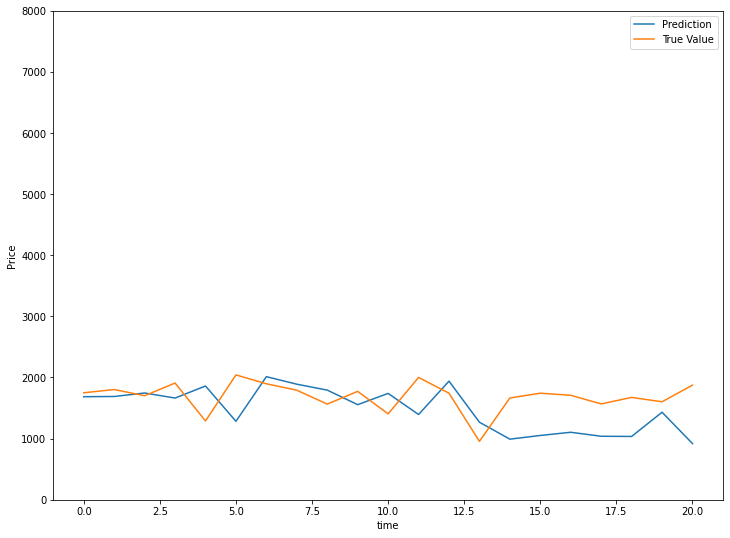

In [ ]:
# 14일 후를 예측한 가격의 그래프

plt.figure(figsize=(12, 9))
plt.plot(predicts)
plt.plot(real_value14['가격'].reset_index(drop = True))
plt.ylabel('Price')
plt.xlabel('time')
plt.ylim(0,8000)
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.show()

## 28일 예측(비시계열) - 토마토

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/선대팀_주제분석/최종데이터/carrot_lag28.csv",encoding = 'cp949')

In [ ]:
data = data.dropna().reset_index(drop = True)

In [ ]:
data # 지울 예정

,date,요일,가격,daedong_stock,서울대_s1
0,2016.1.4,월요일,794,9130.000000,0.018634
1,2016.1.5,화요일,763,9100.000000,0.204059
2,2016.1.6,수요일,787,9030.000000,0.111111
3,2016.1.7,목요일,770,9040.000000,0.158940
4,2016.1.8,금요일,705,8930.000000,0.094545
...,...,...,...,...,...
1456,2020.9.23,수요일,1792,6460.000000,0.082858
1457,2020.9.24,목요일,1565,6240.000000,0.078228
1458,2020.9.25,금요일,1773,6180.000000,0.077933
1459,2020.9.26,토요일,1405,6264.323351,0.077845


In [ ]:
dates = data['date'].copy()

In [ ]:
data28 = data.copy()

remove_list28 = list()

for i in list(data28.index) : 
  try:
    if data28['요일'][i] != data28['요일'][i+22] and data28['요일'][i] != data28['요일'][i+23] and data28['요일'][i] != data28['요일'][i+24] :
      remove_list28.append(i)
  except:
    break

data28 = data28.drop(remove_list28, axis = 0).reset_index(drop = True)

In [ ]:
day = 24

data28['가격'][:-day] = data28['가격'][day:]
data28['가격'][-day:] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# validation할 기간은 2020-07-07의 28일 후 ~ 2020-08-03의 28일 후

last_day28 = list(data28['date']).index('2020.8.31')

train28 = data28.iloc[:last_day28+1, :]

In [ ]:
# X와 y를 분리합시다. 

train28_X, train28_y = splitFunction(train28)

In [ ]:
test_index = list(train28['date'].reset_index(drop = True)).index("2020.7.7") # 우리가 비교할 첫 날짜 

In [ ]:
class JHLeeTimeSeriesSplit() : 
  def __init__(self) :
    self.data = train28 # CV에 이용할 데이터는 train이겠죠

  def get_n_splits(self, groups) : 
    return  
  
  def split(self, X, y = None, groups = None) :
    
    #test_index = list(self.data).index('2020.7.7') # 우리가 비교할 첫 날짜

    for day in range(24) : # 28-4(일요일)일간의 기간을 평가해봅시다

      train_split_data = train.iloc[:test_index+day,:] # 각 시행시 test하는 날짜 전까지가 train
      train_indices = list(train_split_data.index)

      test_indices = list()
      test_indices.append(test_index+day) # test할 날짜를 저장

      yield train_indices, test_indices

In [ ]:
def XGB_cv(max_depth, gamma) : # 괄호 안에는 각 모델에서 튜닝할 parameter들과 데이터들을 넣으면 됩니다.

  # 모델 선언
  # 참고로, 베이지안 최적화는 항상 실수값이 인풋으로 들어가므로, max_depth처럼
  # 정수형 인자를 필요로 하는경우 반드시 int나 round를 사용해 정수형으로 만들어줘야합니다.
  model = XGBRegressor(random_state = 1234,
                            max_depth = int(max_depth),
                            gamma = gamma,
                            objective = 'reg:squarederror')


  cv = JHLeeTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                    train_X,
                                    train_y,
                                    cv = cv,
                                    scoring = 'neg_mean_squared_error') # -MSE를 의미

  rmse_scores_part = np.sqrt(-mse_scores_part) # -(-MSE)의 sqrt = RMSE    
  rmse_scores = np.mean(rmse_scores_part) # 28일동안 평가했으므로 28일간의 평균 rmse가 필요

  return -rmse_scores # 베이지안 최적화에서는 최대값만을 기준으로 할 수 있으므로 -을 붙이고 최대를 구하면 실은 최소값을 구하는 것                          

In [ ]:
# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"max_depth" : (1, 10),
           "gamma" : (0.01, 5000)}

In [ ]:
train_X, train_y = train28_x.drop(['date','요일'],axis = 1), train28_y
BO = BayesianOptimization(f = XGB_cv, # 위에서 정의한 cv 함수
                        pbounds = pbounds, # 위에서 정의한 파라미터들의 범위
                        verbose = 2, # 과정을 나타내줌
                        random_state = 1234) # 시드 고정 필수
BO.maximize(init_points = 10, n_iter = 10, acq = 'ei',xi = 0.01) # init point는 시작할 때의 개수, n_iter는 그 이후에 돌릴 개수

|   iter    |  target   |   gamma   | max_depth |
-------------------------------------------------
|  1        | -235.0    |  957.6    |  6.599    |
|  2        | -225.7    |  2.189e+0 |  8.068    |
|  3        | -234.2    |  3.9e+03  |  3.453    |
|  4        | -225.2    |  1.382e+0 |  8.217    |
|  5        | -224.8    |  4.791e+0 |  8.883    |
|  6        | -230.5    |  1.789e+0 |  5.509    |
|  7        | -233.9    |  3.417e+0 |  7.414    |
|  8        | -229.6    |  1.851e+0 |  6.051    |
|  9        | -257.4    |  2.515e+0 |  1.124    |
|  10       | -223.3    |  3.864e+0 |  8.944    |
|  11       | -229.9    |  4.791e+0 |  9.035    |
|  12       | -229.2    |  1.925e+0 |  5.849    |
|  13       | -229.9    |  4.791e+0 |  9.001    |
|  14       | -234.3    |  925.1    |  6.743    |
|  15       | -247.7    |  1.354e+0 |  2.584    |
|  16       | -217.5    |  3.243e+0 |  8.49     |
|  17       | -225.2    |  2.188e+0 |  8.216    |
|  18       | -226.3    |  456.1    |  8.669    |


In [ ]:
# 모델 생성
parameters = BO.max['params']# 위의 결과들을 딕셔너리로 반환시켜준다.

# 최적의 조합
max_depth = int(parameters['max_depth'])
gamma = parameters['gamma']
print("rmse: %.3f,  gamma: %d, max_depth: %d"%(-BO.max['target'],gamma, max_depth))
model28 = XGBRegressor(random_state = 1234,
                        max_depth = max_depth,
                        gamma = gamma,
                        objective = 'reg:squarederror')

rmse: 217.533,  gamma: 3243, max_depth: 8


In [ ]:
start_28 = list(carrot_real_y['date']).index('2020.9.29')
end_28 = list(carrot_real_y['date']).index('2020.10.26')

In [ ]:
real_value28 = carrot_real_y[start_28 : end_28+1].reset_index(drop = True)

In [ ]:
# 28일 후가 공휴일인 날을 제외한 예측 가능한 날짜 

predict_day28 = ['2020.9.1', '2020.9.2', '2020.9.7',
'2020.9.8', '2020.9.9', '2020.9.10', '2020.9.11', '2020.9.12', '2020.9.14', '2020.9.15', '2020.9.16', 
'2020.9.17', '2020.9.18', '2020.9.19', '2020.9.21', '2020.9.22', '2020.9.23', '2020.9.24',
 '2020.9.25', '2020.9.26', '2020.9.28']

In [ ]:
# predict

predicts = list() # predict 값들을 넣을 리스트 
test_index = list(data28['date'].reset_index(drop = True)).index(predict_day28)

new_train = data28.iloc[:test_index, :].copy()
new_train = new_train.dropna().reset_index(drop = True)

train_X = new_train.drop(['date','요일','가격'], axis = 1).reset_index(drop = True)
train_y = new_train['가격'].reset_index(drop = True)

new_test = data28.drop(['date','요일','가격'],axis = 1).reset_index(drop = True)
test_X = new_test.iloc[test_index-1: test_index]

model28.fit(train_X, train_y)
predict = model28.predict(test_X)  # 하루에 대한 예측값
predicts.append(predict) # 하루하루 예측값을 각각 predicts라는 리스트에 저장

In [ ]:
mse28 = mean_squared_error(predicts, real_value28['가격'].reset_index(drop = True))
rmse28 = math.sqrt(mse28)
print(rmse28)

309.66645357264815


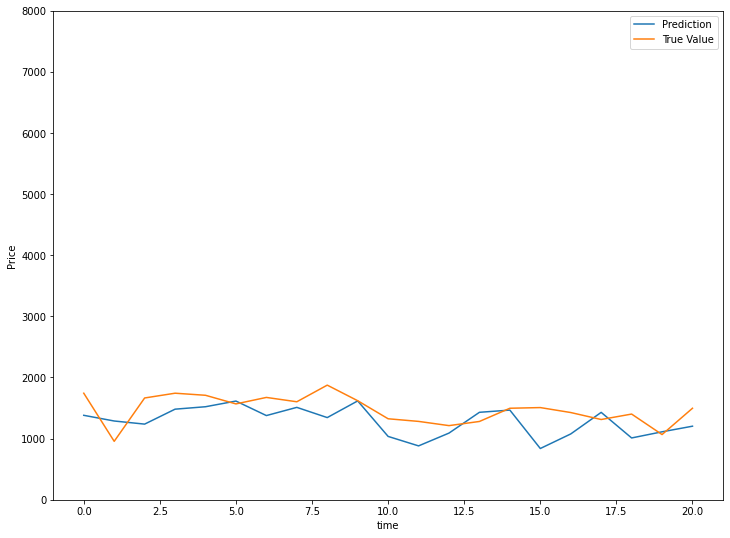

In [ ]:
# 28일 후를 예측한 가격의 그래프

plt.figure(figsize=(12, 9))
plt.plot(predicts)
plt.plot(real_value28['가격'].reset_index(drop = True))
plt.ylabel('Price')
plt.xlabel('time')
plt.ylim(0,8000)
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.show()